In [47]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

# Fetching data and preprocessing

In [3]:
import yfinance as yf
import pandas as pd

tickers = ["^DJI", "^GSPC", "^IXIC"]
start_date = "2024-01-01"
end_date = "2025-01-01"

# Download data with auto_adjust=True
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    interval="1d",
    group_by="ticker",
    auto_adjust=True
)

# Create an empty DataFrame to hold all Close prices
close_df = pd.DataFrame()

for ticker in tickers:
    # Extract Close prices with ticker name as column name
    close_df[ticker.replace('^', '')] = data[ticker]['Close']

# The index is already the date, but just to be sure:
close_df.index = pd.to_datetime(close_df.index)

print(close_df.head())


[*********************100%***********************]  3 of 3 completed

                     DJI         GSPC          IXIC
Date                                               
2024-01-02  37715.039062  4742.830078  14765.940430
2024-01-03  37430.191406  4704.810059  14592.209961
2024-01-04  37440.339844  4688.680176  14510.299805
2024-01-05  37466.109375  4697.240234  14524.070312
2024-01-08  37683.011719  4763.540039  14843.769531


In [4]:
def add_focused_outliers(Y, begin_idx, num_outliers, y_value):
    """
    Replace `num_outliers` values in the first column of Y starting from `begin_idx` with `y_value`.

    Parameters:
    Y (np.ndarray): Original N x D array
    begin_idx (int): Starting index for the outliers
    num_outliers (int): Number of outliers to insert
    y_value (float): The value to use for the outliers

    Returns:
    np.ndarray: Modified array with outliers
    """
    Y_with_outliers = Y.copy()
    end_idx = min(begin_idx + num_outliers, Y.shape[0])  # prevent going out of bounds
    Y_with_outliers[begin_idx:end_idx, 0] = y_value
    return Y_with_outliers

def vshaped_outliers(Y, begin_idx, y_values):
    """
    Replace values in the first column of Y starting from `begin_idx` with 
    the original value multiplied by corresponding values in `y_values`.

    Parameters:
    Y (np.ndarray): Original N x D array
    begin_idx (int): Starting index for modifying values
    y_values (list of float): List of fractions to multiply with the original values

    Returns:
    np.ndarray: Modified array with V-shaped outliers
    """
    Y_modified = Y.copy()
    end_idx = min(begin_idx + len(y_values), Y.shape[0])  # avoid going out of bounds
    num_replace = end_idx - begin_idx  # actual number of values to replace

    # Convert y_values to a numpy array in case it's a list
    y_values_arr = np.array(y_values[:num_replace])

    # Apply the transformation
    Y_modified[begin_idx:end_idx, 0] *= y_values_arr

    return Y_modified

X shape: (252, 1)
Y shape: (252, 3)


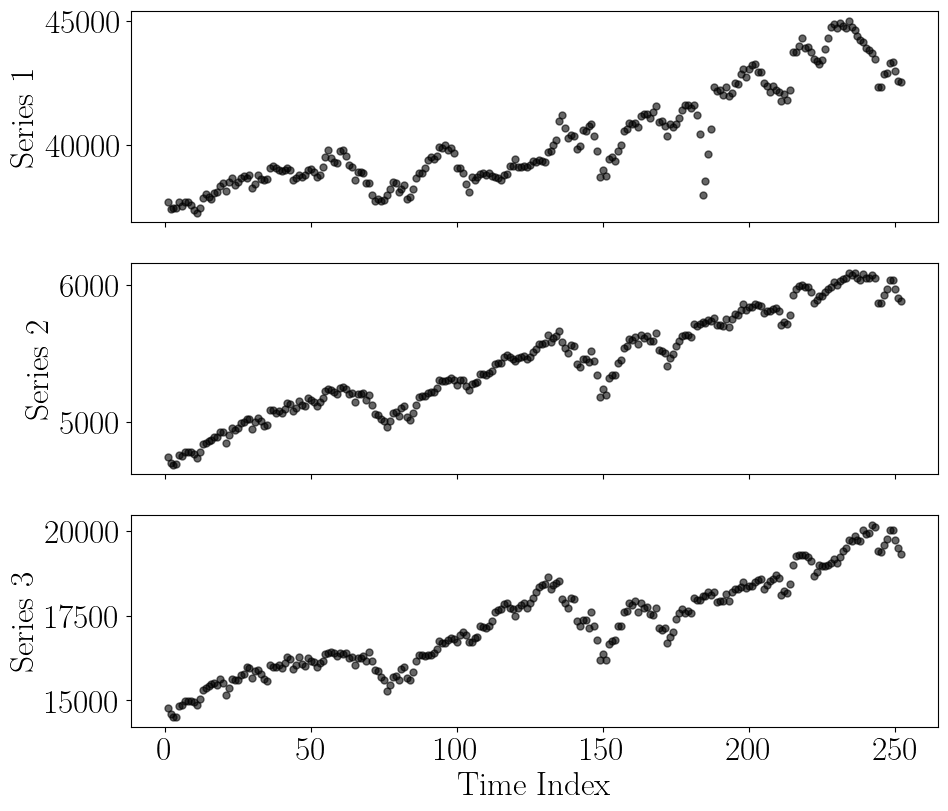

In [35]:
# Drop any rows with missing values to ensure clean arrays
clean_df = close_df.dropna()

# Number of data points (N)
N = clean_df.shape[0]

# Create X: array from 1 to N, shape (N, 1)
X = np.arange(1, N + 1).reshape(-1, 1)

# Create Y: Close prices as (N, 4) array
Y = clean_df.to_numpy()

# Optional: check shapes
print("X shape:", X.shape)  # (N, 1)
print("Y shape:", Y.shape)  # (N, 4)

# Y_with_outliers = add_focused_outliers(Y, 120, 10, 35_000)
Y_with_outliers = vshaped_outliers(Y=Y, begin_idx=180, y_values=[0.99, 0.98, 0.96, 0.9, 0.92, 0.94, 0.96])


# PLOTTING
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Plot each Y column in its respective subplot
for i in range(3):
    axes[i].plot(X, Y_with_outliers[:, i], 'o', color='black', alpha=0.6)
    axes[i].set_ylabel(f"Series {i+1}")

# Set common x-label
axes[-1].set_xlabel("Time Index")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [36]:
scaler_Y_outliers = StandardScaler()
Y_with_outliers_standardized = scaler_Y_outliers.fit_transform(Y_with_outliers)

scaler_Y = StandardScaler()
Y_standardized = scaler_Y.fit_transform(Y)

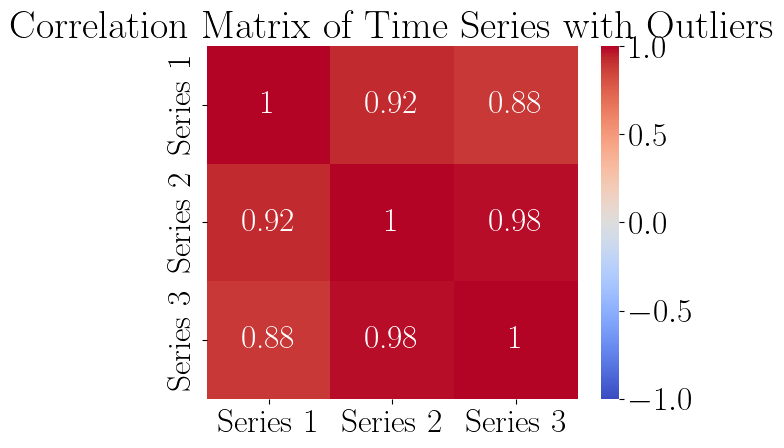

In [37]:
# Compute the correlation matrix
corr_matrix = np.corrcoef(Y_with_outliers.T)

# Plot the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=[f'Series {i+1}' for i in range(3)],
            yticklabels=[f'Series {i+1}' for i in range(3)])
plt.title("Correlation Matrix of Time Series with Outliers")
plt.tight_layout()
plt.show()

## MOGP

fitted data
106.89603318628497
106.89603453075631
106.8960332768105
106.89603352445477
106.89603271760063
106.8960411464194
106.89602624644306
106.8960207264887
106.89604281996321
106.89603781900541
106.89602990112701
-280.28693182499467
-280.28692998126974
-280.2869311674258
-280.28693206243327
-280.2869287818537
-280.2869324109573
-280.2869369493744
-280.2869316513328
-280.2869356265444
-280.2869316136989
-280.28692209977
89.2917211056789
89.29172232407132
89.29172068444166
89.29172103947485
89.29172172862934
89.29172124284003
89.2917197696512
89.29172487577455
89.29171096429684
89.29171629774112
89.2917338996017
199.6025513121375
199.60255249698037
199.60255092466434
199.60255101545783
199.60255098923903
199.60255216974122
199.60255159120504
199.60254925079482
199.60254781107187
199.60255229125335
199.60255469029937
211.42059519575275
211.42059634767463
211.42059480366777
211.42059484790445
211.42059482872412
211.42059590524127
211.42059516455117
211.42059332704196
211.4205929907729

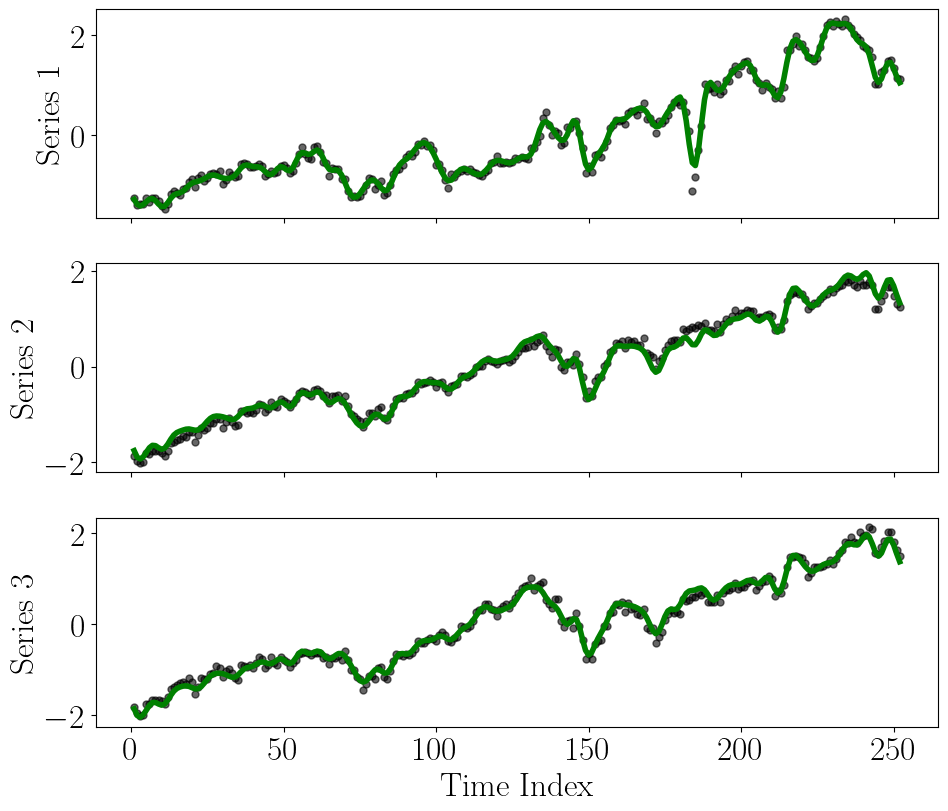

In [42]:
initial_A = generate_A(d = 3, r = 2)
mogp = MOGPRegressor(mean=0, length_scale=3.4, noise=np.array([0.02]*3), A=initial_A)
mogp.fit(X, Y_with_outliers_standardized)
print('fitted data')
# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=True, print_iter_param=True)
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

mu_mogp_standardized, var_mogp_standardized = mogp.predict(X)
# std_mogp = np.sqrt(var_mogp + mogp.noise)

# PLOTTING
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Plot each Y column in its respective subplot
for i in range(3):
    axes[i].plot(X, Y_with_outliers_standardized[:, i], 'o', color='black', alpha=0.6)
    axes[i].plot(X, mu_mogp_standardized[:, i], '-', color='green')
    axes[i].set_ylabel(f"Series {i+1}")

# Set common x-label
axes[-1].set_xlabel("Time Index")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [44]:
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X, Y_with_outliers_standardized, B_weighted=optim_B, noise_weighted=optim_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, update_weights=True)

mu_morcgp_standardized, var_morcgp_standardized = morcgp.predict(X)
# std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

450.72210116875897
450.72210067001765
450.7221008203219
450.7221009033827
450.7221007726549
450.72210089060474
450.7221013201769
450.7221024433059
450.7221009171272
450.7221002469757
450.72210135516735
-618.043059947824
-618.0430585947387
-618.043049469655
-618.0430581672961
-618.043059644618
-618.0430460632223
-618.0430342821089
-618.0430674677766
-618.0430733797816
-618.043063935004
-618.0430678756665
449.4527685203602
449.45276807434954
449.452768173736
449.45276830236793
449.4527681185197
449.4527693639586
449.45276878522384
449.4527658292775
449.452767989655
449.45277056548684
449.4527688830249
451.82586118502144
451.8258607057358
451.825860836146
451.8258609259454
451.82586078060336
451.8258612884957
451.8258613763691
451.8258608548655
451.8258608222714
451.8258615177217
451.8258614458533
Optimized length_scale: 3.3629
Optimized noise: [0.00999441 0.0133084  0.01103826]
Optimized A: [[0.68909718 0.40259306]
 [0.42940072 0.61406428]
 [0.32376966 0.66613162]]
Optimized B: 
[[0.6369

In [51]:
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=3.5, noise = optim_noise, A=optim_A, epsilons=np.array([7/252, 0, 0]))
morcgp.fit(X, Y_with_outliers_standardized)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )


mu_pm_standardized, _ = morcgp.predict(X)

463.5247829087494
463.52478155194257
463.5247827904459
463.52478286242615
463.5247828264054
463.52478297749093
463.5247828878576
463.52478378596777
463.52478306016116
463.5247821199002
463.5247828905861
-1263.4299463699263
-1263.4299382329332
-1263.4299356467054
-1263.4299400748998
-1263.429946650757
-1263.4299264147564
-1263.4298824959703
-1263.429963074616
-1263.4299963724973
-1263.4299407520427
-1263.4299318170536
464.675579072439
464.67557796019486
464.6755789507407
464.6755790422333
464.67557897193404
464.6755798895415
464.675579358108
464.6755769095827
464.67557815613867
464.6755806539488
464.67557983397944
Optimized length_scale: 3.4289
Optimized noise: [0.01000004 0.01332293 0.01105404]
Optimized A: [[0.6920146  0.4012549 ]
 [0.43406423 0.61805302]
 [0.3180613  0.66459852]]
Optimized B: 
[[0.63988971 0.54837559 0.48677648]
 [0.54837559 0.57040129 0.54881615]
 [0.48677648 0.54881615 0.54285418]]


In [52]:
mu_mogp = scaler_Y_outliers.inverse_transform(mu_mogp_standardized)
mu_morcgp = scaler_Y_outliers.inverse_transform(mu_morcgp_standardized)
mu_pm = scaler_Y_outliers.inverse_transform(mu_pm_standardized)

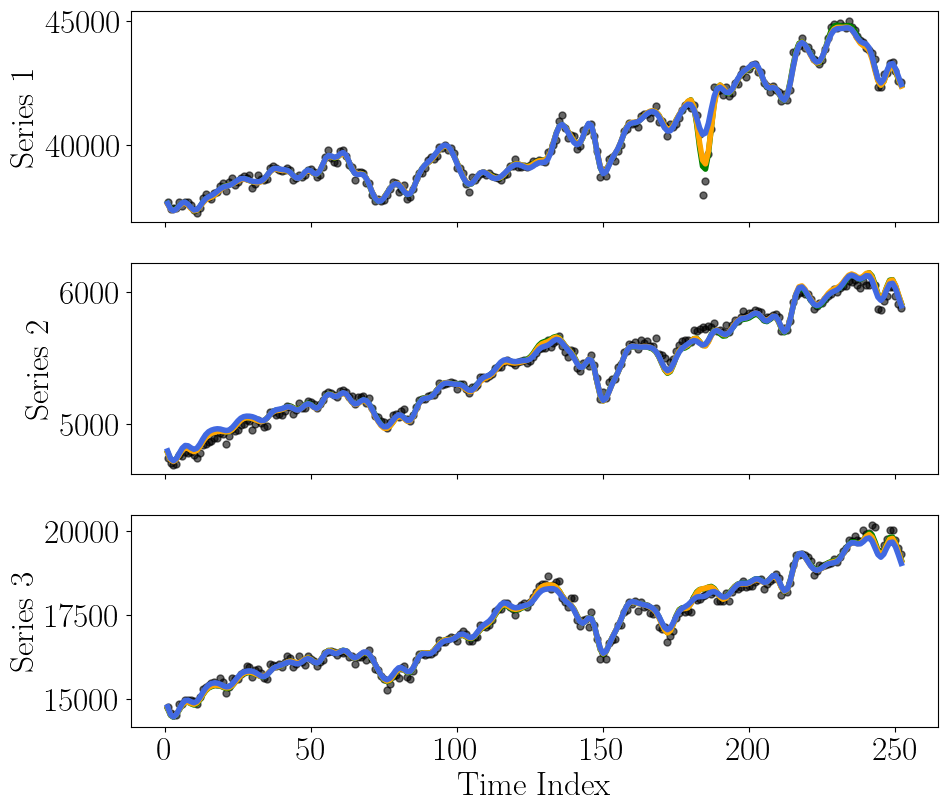

In [53]:
# PLOTTING
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Plot each Y column in its respective subplot
for i in range(3):
    axes[i].plot(X, Y_with_outliers[:, i], 'o', color='black', alpha=0.6)
    axes[i].plot(X, mu_mogp[:, i], '-', color='Green')
    axes[i].plot(X, mu_pm[:, i], '-', color='orange')
    axes[i].plot(X, mu_morcgp[:, i], '-', color='RoyalBlue')
    axes[i].set_ylabel(f"Series {i+1}")

# Set common x-label
axes[-1].set_xlabel("Time Index")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()